In [24]:
### Import packages

In [25]:
# !pip install evodcinv --user 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from evodcinv import EarthModel, Layer, Curve
from disba import PhaseDispersion, GroupDispersion

In [2]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from disba import Ellipticity, depthplot, resample, surf96

from disba import Ellipticity, depthplot, resample, surf96
from disba._common import ifunc
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from joblib import Parallel, delayed




cmap = cm.get_cmap('gnuplot2')
cmap = ListedColormap(cmap(np.linspace(0.1, 0.9, 256)))

cmap = cm.get_cmap('gray')
cmap = ListedColormap(cmap(np.linspace(0, 0.9, 256)))

In [3]:
def plot_predicted_curve(inv_result, period, mode, wave, type, show="best", stride=1, percent=10, 
                         plot_args=None, ax=None):
    
    if type not in {"phase", "group", "ellipticity"}:
        raise ValueError()
    
    # Default parameters
    n_jobs = -1
    dc = 0.001
    dt = 0.01
    itype = {"phase": 0, "group": 1}
    units = {"frequency": "Hz", "period": "s"}
    
    # Model dispersion curves
    def get_y(thickness, velocity_p, velocity_s, density):
        c = surf96(period, thickness, velocity_p, velocity_s, density, mode, 
                   itype[type], ifunc["dunkin"][wave], dc, dt)
        idx = c > 0.0
        return c[idx]
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"type": "line", "xaxis": "period", "yaxis": "velocity", "cmap": "Oranges_r"}
    _plot_args.update(plot_args)

    plot_type = _plot_args.pop("type")
    xaxis = _plot_args.pop("xaxis")
    yaxis = _plot_args.pop("yaxis")
    cmap = _plot_args.pop("cmap")
    
    plot_type = plot_type if plot_type != "line" else "plot"
    plot = getattr(plt if ax is None else ax, plot_type)
    x = 1.0 / period if xaxis == "frequency" else period
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot curves from %d models.' %misfits.shape[0])

        # Make colormap
        norm = Normalize(misfits.min(), misfits.max())
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Generate and plot curves
        curves = Parallel(n_jobs=n_jobs)(delayed(get_y)(*model.T) for model in models)
        for curve, misfit in zip(curves, misfits):
            y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
            plot(x[: len(y)], y, color=smap.to_rgba(misfit), **_plot_args)

    elif show == "best":
        curve = get_y(*inv_result.model.T)
        y = y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
        plot(x[: len(y)], y, **_plot_args)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()

    xlabel = f"{xaxis.capitalize()} [{units[xaxis]}]"
    ylabel = f"{type.capitalize()} "
    ylabel += f"{yaxis} [m/s]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)

    # Disable exponential tick labels
    gca.xaxis.set_major_formatter(ScalarFormatter())
    gca.xaxis.set_minor_formatter(ScalarFormatter())
    
    
def plot_model(inv_result, parameter, show="best", stride=1, percent=10, zmax=None, 
               plot_args=None, ax=None, cmap_on=False, cmap_args=None, cmap_range=None):
    
    parameters = {
            "velocity_p": 1,
            "velocity_s": 2,
            "density": 3,
            "vp": 1,
            "vs": 2,
            "rho": 3,
    }
    
    if parameter not in parameters:
        raise ValueError()
    i_param = parameters[parameter]
        
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"cmap": "gist_ncar", "color": "black", "linewidth": 2}
    _plot_args.update(plot_args)

    cmap = _plot_args.pop("cmap")
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot %d models.' %misfits.shape[0])

        # Make colormap
        if cmap_range is None:
            norm = Normalize(misfits.min(), misfits.max())
        else:
            norm = Normalize(cmap_range[0], cmap_range[1])
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Plot models
        for model, misfit in zip(models, misfits):
            tmp = {k: v for k, v in _plot_args.items()}
            tmp["color"] = smap.to_rgba(misfit)
            depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=tmp, ax=ax)

    elif show == "best":
        model = inv_result.model
        depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    elif show == "mean":
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[:n_select+1]
        print('Plot mean of %d models.' %models.shape[0])
        print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))
        
        # Plot mean model
        model_mean = np.squeeze(np.mean(models, axis=0))
        depthplot(model_mean[:, 0]*1e3, model_mean[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()
    labels = {
        "velocity_p": "P-wave velocity [m/s]",
        "velocity_s": "S-wave velocity [m/s]",
        "density": "Density [$kg/m^3$]",
        "vp": "$V_p$ [m/s]",
        "vs": "$V_s$ [m/s]",
        "rho": "$\\rho$ [$kg/m^3$]",
    }
    xlabel = labels[parameter]
    ylabel = "Depth [m]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)
    
    # # Colorbar
    # if cmap_on:
    #     cmap_args = cmap_args if cmap_args is not None else {}
    #     _cmap_args = {"orientation": "vertical", "label": "Log Misfit", "location": "right"}
    #     _cmap_args.update(cmap_args)
    #     plt.colorbar(smap, **_cmap_args)
        
        
def plot_model_range(model, plot_args=None, ax=None):
    
    d1 = np.array([])
    vs1 = np.array([])
    d2 = np.array([])
    vs2 = np.array([])
    
    for layer in model.layers:
        d1 = np.append(d1, layer.thickness[1])
        vs1 = np.append(vs1, layer.velocity_s[0])
        d2 = np.append(d2, layer.thickness[0])
        vs2 = np.append(vs2, layer.velocity_s[1])
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"color": "black", "linewidth": 2}
    _plot_args.update(plot_args)
    
    d2[-1] = np.sum(d1) - np.sum(d2[:-1])
    depthplot(d1*1e3, vs1*1e3, None, plot_args=_plot_args, ax=ax)
    depthplot(d2*1e3, vs2*1e3, None, plot_args=_plot_args, ax=ax)
    

def model_param_range(inv_result, percent=30, stride=None, plot_nu=False):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.xs[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    if stride is None:
        stride = int(n_select // 4)
    models = models[n_select::-stride]
    n_model = models.shape[0]
    print('Record %d models.' %n_model)
    
    # Model parameters
    n_layer = int((len(models[0])+1) // 3)
    h = np.percentile(models[:, :n_layer-1], [0,25,50,75,100], axis=0)
    vs = np.percentile(models[:, n_layer-1:2*n_layer-1], [0,25,50,75,100], axis=0)
    nu = np.percentile(models[:, 2*n_layer-1:], [0,25,50,75,100], axis=0)
    
    # Print 0, 25, 50, 75, 100 percentiles
    for i in range(n_layer):
        print('Layer %d' %i)
        if i < n_layer - 1:
            print('Thickness [km]: %.4f, %.4f, %.4f, %.4f %.4f' %(h[0,i], h[1,i], h[2,i], h[3,i], h[-1,i]))
        print('Vs [km/s]: %.4f, %.4f, %.4f, %.4f %.4f' %(vs[0,i], vs[1,i], vs[2,i], vs[3,i], vs[-1,i]))
        print('Nu: %.4f, %.4f, %.4f, %.4f %.4f' %(nu[0,i], nu[1,i], nu[2,i], nu[3,i], nu[-1,i]))
        print()

    if plot_nu:
        nu = models[n_select::-1, 2*n_layer-1:]
        for i in range(n_layer):
            plt.figure(figsize=(8,8))
            plt.hist(nu[:, i])
            plt.grid()
            plt.show()
        

def get_mean_model(inv_result, percent=30):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.models[idx]
    misfits = inv_result.misfits[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    models = models[:n_select+1]
    print('Get mean of %d models.' %models.shape[0])
    print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))

    # Return mean model
    model_mean = np.squeeze(np.mean(models, axis=0))
    return model_mean

In [4]:
# Velocity model
# thickness, Vp, Vs, density
# km, km/s, km/s, g/cm3
velocity_model = np.array([
   [0.1, 3.00, 1.50, 2.00],
   [0.1, 2.80, 1.40, 2.00],
   [0.1, 3.00, 1.50, 2.00],
   [0.1, 3.60, 1.80, 2.00],
   [0.1, 3.40, 1.90, 2.00],
   [0.1, 3.00, 2.10, 2.00],
   [0.1, 3.40, 2.20, 2.00],
   [0.1, 3.60, 2.30, 2.00],
])


true_model = {'Depth': np.array([  0, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 0.7, 0.7, 0.8, 0.8, 1.0]), \
              'Vs': np.array([   1.5, 1.5, 1.4, 1.4, 1.5, 1.5, 1.8, 1.8, 1.9, 1.9, 2.1, 2.1, 2.2, 2.2, 2.3, 2.3, 2.3, 2.3])}

In [5]:
# Compute the 3 first Rayleigh- and Love- wave modal dispersion curves
# Fundamental mode corresponds to mode 0
pd = PhaseDispersion(*velocity_model.T)

In [6]:
# Periods must be sorted starting with low periods
t = np.logspace(-1.0, 1.0, 20)

In [7]:
data = [pd(t, mode=i, wave="rayleigh") for i in range(3)]
# data = pd(t, mode=0, wave="rayleigh")

In [10]:
data

[DispersionCurve(period=array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
         0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
         1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
         3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ]), velocity=array([1.38458347, 1.37634739, 1.36915378, 1.36684543, 1.37533054,
        1.40353733, 1.46374119, 1.5663718 , 1.69909763, 1.81479709,
        1.8873032 , 1.92870823, 1.95430027, 1.97270725, 1.98791843,
        2.0014719 , 2.01374607, 2.02470432, 2.03426365, 2.0424094 ]), mode=0, wave='rayleigh', type='phase'),
 DispersionCurve(period=array([0.1       , 0.1274275 , 0.16237767, 0.20691381, 0.26366509,
        0.33598183, 0.42813324, 0.54555948]), velocity=array([1.52748381, 1.59217986, 1.68529875, 1.79792449, 1.92044036,
        2.04758757, 2.16504485, 2.26974333]), mode=1, wave='rayleigh', type='phase'),
 DispersionCurve(period=array([0.1       , 0.1274275 , 0.16237

Text(0.5, 1.0, 'Rayleigh-wave')

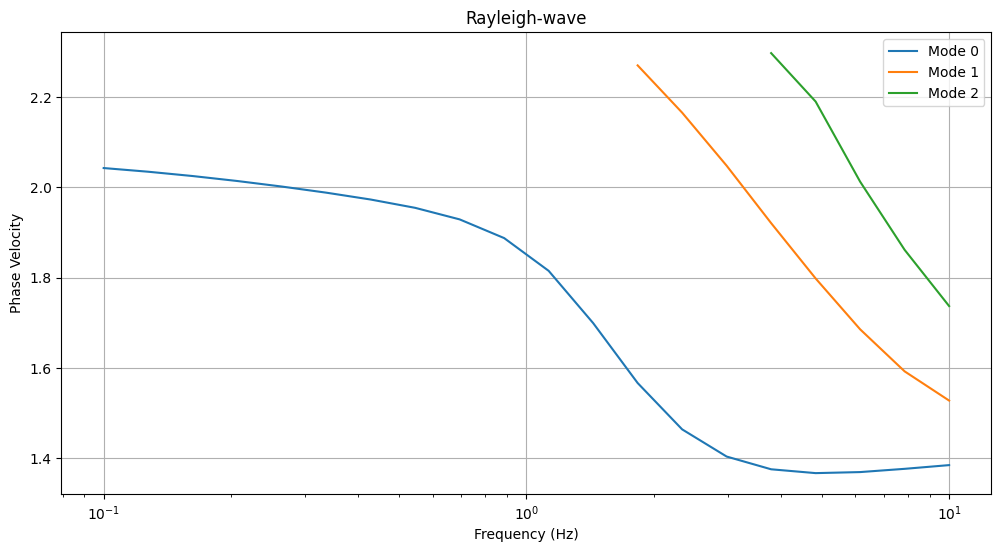

In [34]:
plt.figure(figsize=(12, 6))
for i, d in enumerate (data):
    plt.semilogx(1/d.period, d.velocity, label = 'Mode %d'%(i))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Velocity')
plt.grid()
plt.legend()
plt.title('Rayleigh-wave')

In [44]:
# Initialize model
model = EarthModel()

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))
model.add(Layer([0.08, 0.12], [1.1, 2.5]))


In [59]:

# Configure model
model.configure(
    optimizer="cpso",  # Evolutionary algorithm
    misfit="rmse",  # Misfit function type
    optimizer_args={
        "popsize": 10,  # Population size
        "maxiter": 5000,  # Number of iterations
        "workers": -1,  # Number of cores
        "seed": 0,
    },
)

model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
    0.0800    0.1200    1.1000    2.5000    0.2000    0.4000
------------------------------------------------------------

Number of layers: 8
Number of parameters: 24
--------------------------------------------------------

In [ ]:

# Define the dispersion curves to invert
# period and velocity are assumed to be data arrays
curves = [Curve(data[0].period, data[0].velocity, 0, "rayleigh", "phase"),
          Curve(data[1].period, data[1].velocity, 1, "rayleigh", "phase"),
          Curve(data[2].period, data[2].velocity, 2, "rayleigh", "phase"),
         ]

# Run inversion
res = model.invert(curves, maxrun=1)

Run 1   |█████████████████   |  84% [0:01:24 / 0:00:15] - Misfit: 0.0086

In [61]:
print(res)

--------------------------------------------------------------------------------
Best model out of 50000 models (1 run)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0891    2.8896    1.5097    2.1988              0.0891    1.5097    0.3123
    0.0992    2.6695    1.4162    2.1428              0.0992    1.4162    0.3042
    0.0837    3.2735    1.4969    2.2788              0.0837    1.4969    0.3678
    0.0829    3.2945    1.5179    2.2827              0.0829    1.5179    0.3653
    0.0800    3.3719    2.0649    2.2966              0.0800    2.0649    0.2000
    0.0827    3.1467    1.9270    2.2545              0.0827    1.9270    0.2000
  

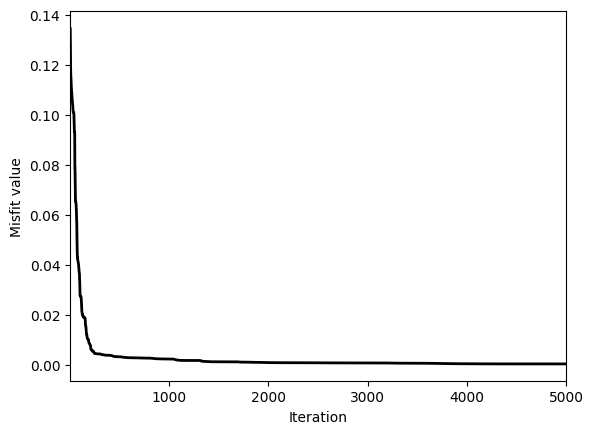

In [67]:
res.plot_misfit()

In [68]:
# res.plot_model('vs', show='all')

In [ ]:
# Colormap: YlGnBu_r, winter

param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plot_model(res, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res, param, show='best', plot_args={"color":"blue", "linewidth":4, "linestyle":"--"})
plot_model(res, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)
obj3, = ax.plot(true_model['Vs']*1e3, true_model['Depth']*1e3, linestyle='--', color='cyan', 
                linewidth=5, alpha=1, label='True model')

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2, obj3], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))


ax.set_ylim([1005, 0])
ax.set_xlim([1000, 2600])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)

Plot 500 models.
Plot mean of 15001 models.
Misfit range: 0.0005, 0.0007.


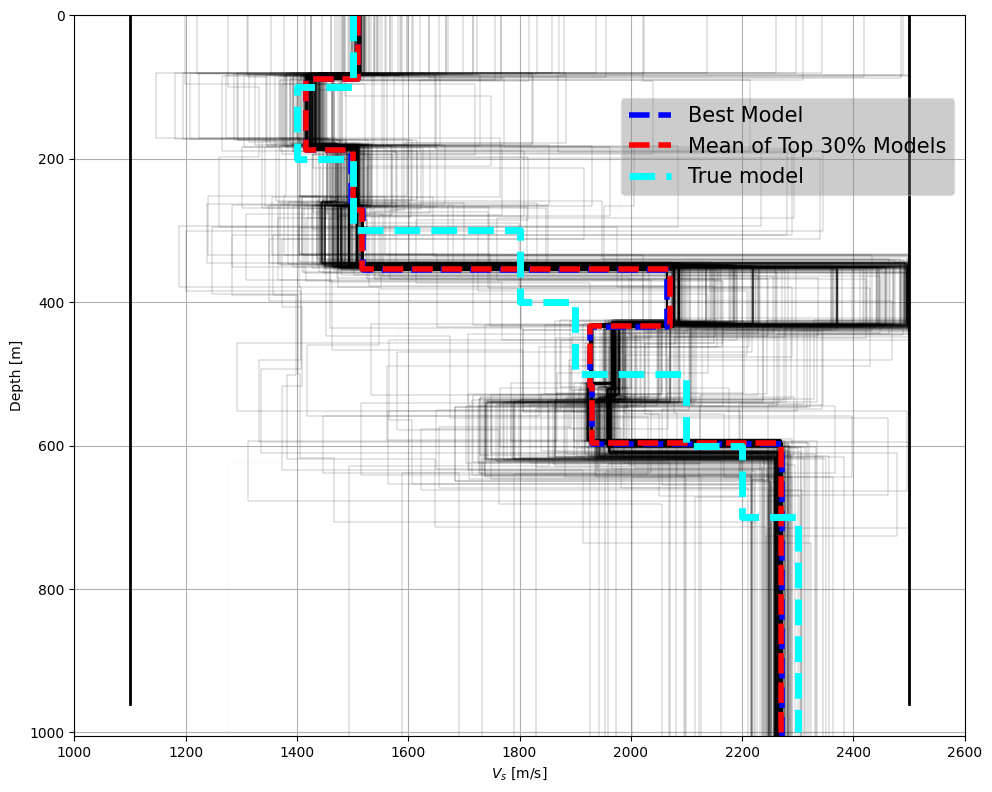

In [69]:
# Colormap: YlGnBu_r, winter

param = 'vs'
show = 'percentage'
percent = 100
stride = 100
cmap_range = (0.8, 2) # (-0.2, 1.5), (0.8, 2)

fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plot_model(res, param, show=show, stride=stride, percent=percent, 
           plot_args={"cmap":cmap, "linewidth":0.15}, ax=ax, 
           cmap_on=True, cmap_args={"label":"Log L2-Misfit"}, cmap_range=cmap_range)
plot_model(res, param, show='best', plot_args={"color":"blue", "linewidth":4, "linestyle":"--"})
plot_model(res, param, show='mean', percent=30, plot_args={"color":"red", "linewidth":4, "linestyle":"--"})
plot_model_range(model, ax=ax)
obj3, = ax.plot(true_model['Vs']*1e3, true_model['Depth']*1e3, linestyle='--', color='cyan', 
                linewidth=5, alpha=1, label='True model')

# Legend
obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=4, label='Best Model')
obj2, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=4, label='Mean of Top 30% Models')
ax.legend(handles=[obj1, obj2, obj3], fontsize=15, facecolor='gray', framealpha=0.4, 
          loc='upper right', bbox_to_anchor=(1, 0.9))


ax.set_ylim([1005, 0])
ax.set_xlim([1000, 2600])
plt.tight_layout(pad=1.0)
# plt.savefig('./inversion_new/inv_models_ND.png', dpi=300)